In [1]:
%matplotlib notebook

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import os
import pickle
import sys
sys.path.append("../benchmark/")

## Old Higgs Trajectories

In [9]:
folder = "../benchmark/logs/"
files_higgs = [
    "ho_higgs_coarse_10000.json",
    "ho_higgs_coarse_7500.json",
    "ho_higgs_coarse_5000.json",
]

In [5]:
data_higgs = []
for fn in files_higgs:
    with open(os.path.join(folder, fn), "r") as fh:
        data_higgs.append(json.load(fh))

In [6]:
def plot_hp(data):
    fig, ax = plt.subplots()
    num_iter = len(data['ho'])
    num_hos = len(data['ho'][0]['hparams'])
    time_range = [data['ho'][i]['time'] for i in range(num_iter)]
    
    for h in range(num_hos):
        ax.plot(time_range, [data['ho'][i]['hparams'][h] for i in range(num_iter)])
    ax.set_ylabel("Hyper-parameter values")
    ax.set_xlabel("Time (s)")

    ax2 = ax.twinx()
    ax2.plot(time_range, [data['ho'][i]['val_loss'] for i in range(num_iter)], lw=2, c="k",
             label="Validation loss")
    ax2.plot(time_range[1:], [data['partial_test_errors']['AUC'][i] for i in range(num_iter - 1)],
             lw=2, c='r', linestyle='--', label="Test AUC")
    
    ax2.scatter(time_range[-1], data_higgs[0][-1]['retrain_test_errors']['AUC'], s=90, label="Retrain test AUC")
    
    ax2.legend(loc="best")
    ax2.set_ylabel("Validation loss")
    

<IPython.core.display.Javascript object>


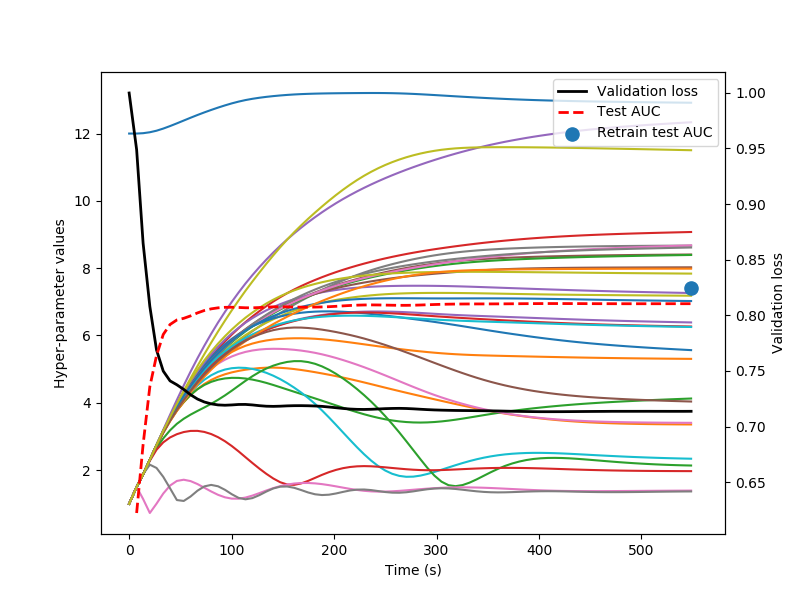

In [64]:
plot_hp(data_higgs[0][-1])

In [8]:
with open(os.path.join(folder, "hotraj_ho-higgs_1607960088133.csv"), "r") as fh:
    traj_data = json.load(fh)
# plot_hp(data_higgs[0][-1])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## Grid search on Different Objectives

In [129]:
def gen_data_loc(e_name, dset):
    d = {}
    for model_name in ["gcv", "loocv", "sgpr", "hgrad-closed", "hgrad-ift", "creg-penfit", "creg-nopenfit"]:
        f = f"../benchmark/logs/{dset}_gs_{model_name}_{e_name}.pkl"
        if os.path.isfile(f):
            d[f"{dset}_{model_name}"] = f
    return d

In [203]:
data_loc = gen_data_loc("test_exp_m100", "boston")
data_loc.update(gen_data_loc("test_exp_m100", "energy"))
data_loc.update(gen_data_loc("test_exp_m100", "ho-higgs"))
data_loc.update(gen_data_loc("test_exp_m100", "protein"))
dict_loc = {}
for k, v in data_loc.items():
    with open(v, 'rb') as fh:
        dict_loc[k] = pickle.load(fh)

In [201]:
dict_loc['ho-higgs_sgpr']

[HPGridPoint(attributes={'Index': 0, 'sigma': 1.0, 'penalty': 1e-06}, results={'loss_log-det': tensor(-68939.3918, dtype=torch.float64), 'loss_data-fit': tensor(4.9900e+09, dtype=torch.float64), 'loss_trace': tensor(4.9900e+09), 'loss_const': tensor(9189.3853, dtype=torch.float64), 'loss': tensor(9.9799e+09, dtype=torch.float64), 'cum_time': 0.09200572967529297, 'train_c-error': 0.4704, 'test_c-error': 0.4692}),
 HPGridPoint(attributes={'Index': 1, 'sigma': 1.0, 'penalty': 3.72759372e-06}, results={'loss_log-det': tensor(-62373.7447, dtype=torch.float64), 'loss_data-fit': tensor(1.3387e+09, dtype=torch.float64), 'loss_trace': tensor(1.3387e+09), 'loss_const': tensor(9189.3853, dtype=torch.float64), 'loss': tensor(2.6773e+09, dtype=torch.float64), 'cum_time': 0.1089468002319336, 'train_c-error': 0.4704, 'test_c-error': 0.46915}),
 HPGridPoint(attributes={'Index': 2, 'sigma': 1.0, 'penalty': 1.38949549e-05}, results={'loss_log-det': tensor(-55808.0819, dtype=torch.float64), 'loss_data-fi

In [198]:
def get_clims(dict_loc, model_attr_list):
    cmin, cmax = 1e99, -1e99
    for i, (obj_name, attr) in enumerate(model_attr_list):
        cmin = min(cmin, min([el.results[attr] for el in dict_loc[obj_name]]))
        cmax = max(cmax, max([el.results[attr] for el in dict_loc[obj_name]]))
    return cmin, cmax
        
def do_plot(obj_name, dict_loc, ax, attr='loss', scale=None, **kwargs):
    log_set = {'sgpr', 'sgpr_new', 'loocv', 'loocv_new', 'hgrad-closed', 'gcv', 'creg-nopenfit'}
    do_log = False
    for log_el in log_set:
        if log_el in obj_name:
            do_log = True
    cdict = dict_loc[obj_name]
    sigmas = [el.attributes['sigma'] for el in cdict]
    penalties = [el.attributes['penalty'] for el in cdict]
    loss = np.asarray([el.results[attr] for el in cdict])
    if do_log:
        loss = np.log(loss)
    if scale == '01':
        min_, max_ = np.min(loss), np.max(loss)
        loss = (loss - min_) / (max_ - min_)
    elif scale == 'zscore':
        mean_, std_ = np.mean(loss), np.std(loss)
        loss = (loss - mean_) / std_
    ax.scatter(sigmas, penalties, c=loss, **kwargs)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Sigma')
    ax.set_ylabel('Penalty')
    if attr != 'loss':
        ax.set_title(attr)
    else:
        ax.set_title(obj_name)
        
def plot_all_models(dset, data_dict, err_name='NRMSE', cbar=False):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6.3))
    ax = ax.flatten()
    for i, (obj_name, attr) in enumerate([
                                  ('%s_sgpr' % dset, 'loss'),
                                  ('%s_loocv' % dset, 'loss'),
                                  ('%s_hgrad-closed' % dset, 'loss'),
                                  ('%s_gcv' % dset, 'loss'),
                                  ('%s_creg-nopenfit' % dset, 'loss'),
                                  ('%s_sgpr' % dset, 'test_%s' % err_name)]):
        do_plot(obj_name, data_dict, ax[i], attr=attr, scale=None, cmap='inferno')

    if cbar:
        # Colorbar
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.89, 0.15, 0.05, 0.7])
        fig.colorbar(ax[-1].collections[0], cax=cbar_ax)
        fig.tight_layout(rect=(0, 0, 0.87, 1))
    else:
        fig.tight_layout()

<IPython.core.display.Javascript object>


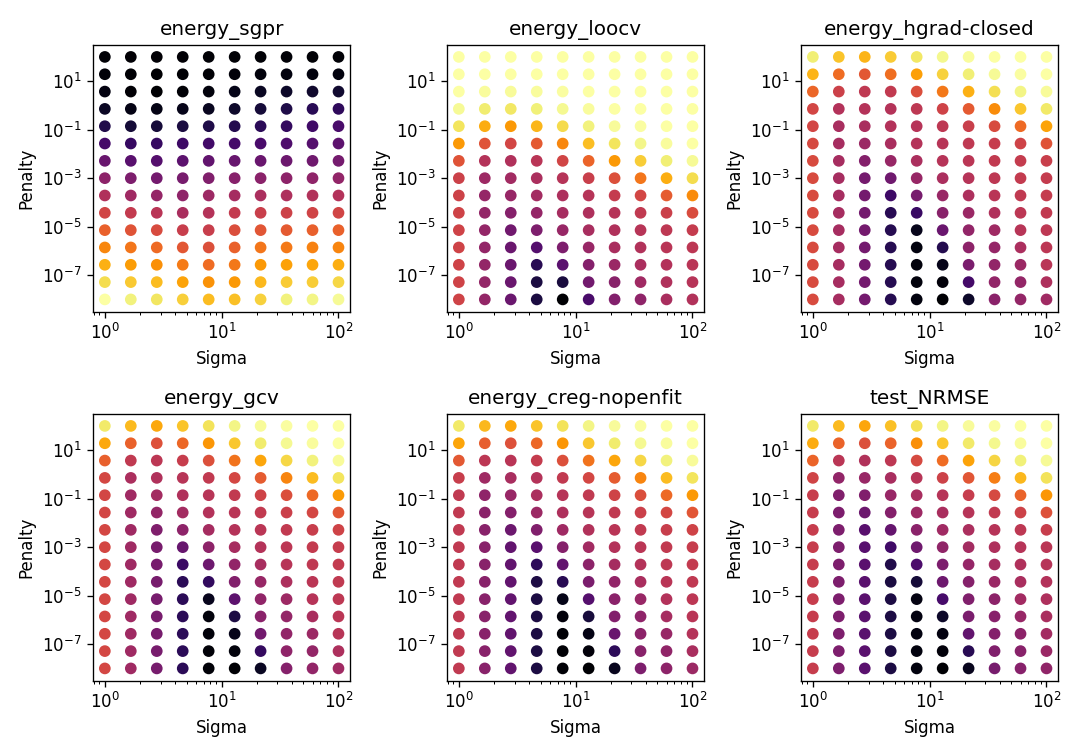

<IPython.core.display.Javascript object>


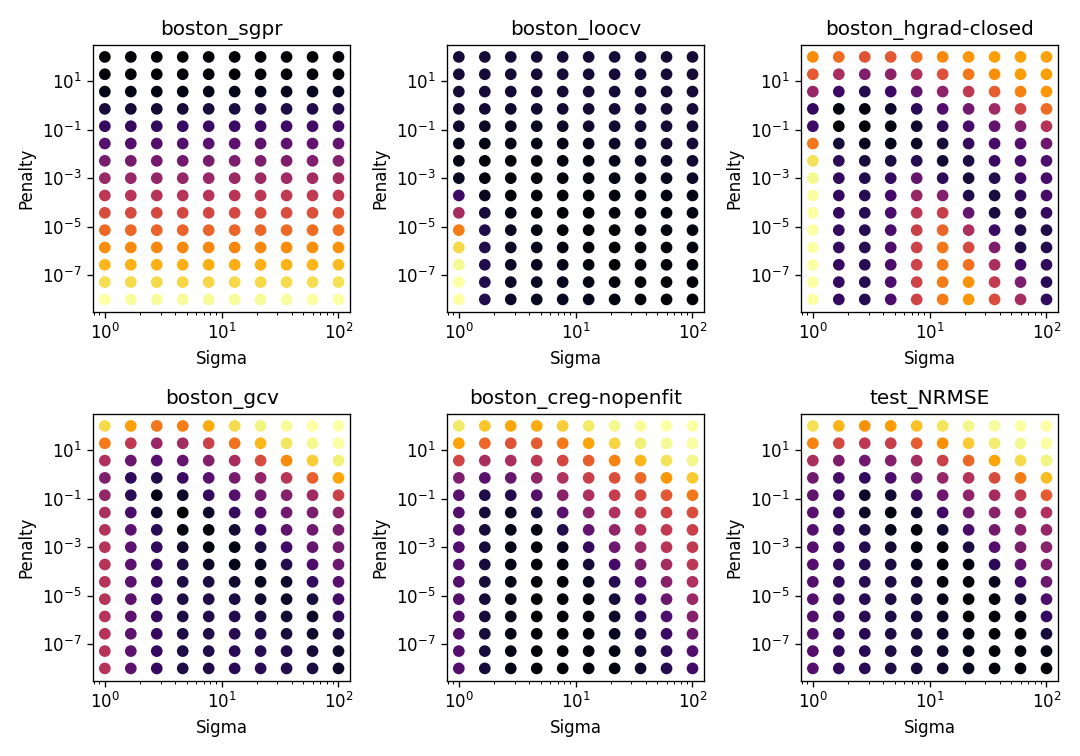

<IPython.core.display.Javascript object>


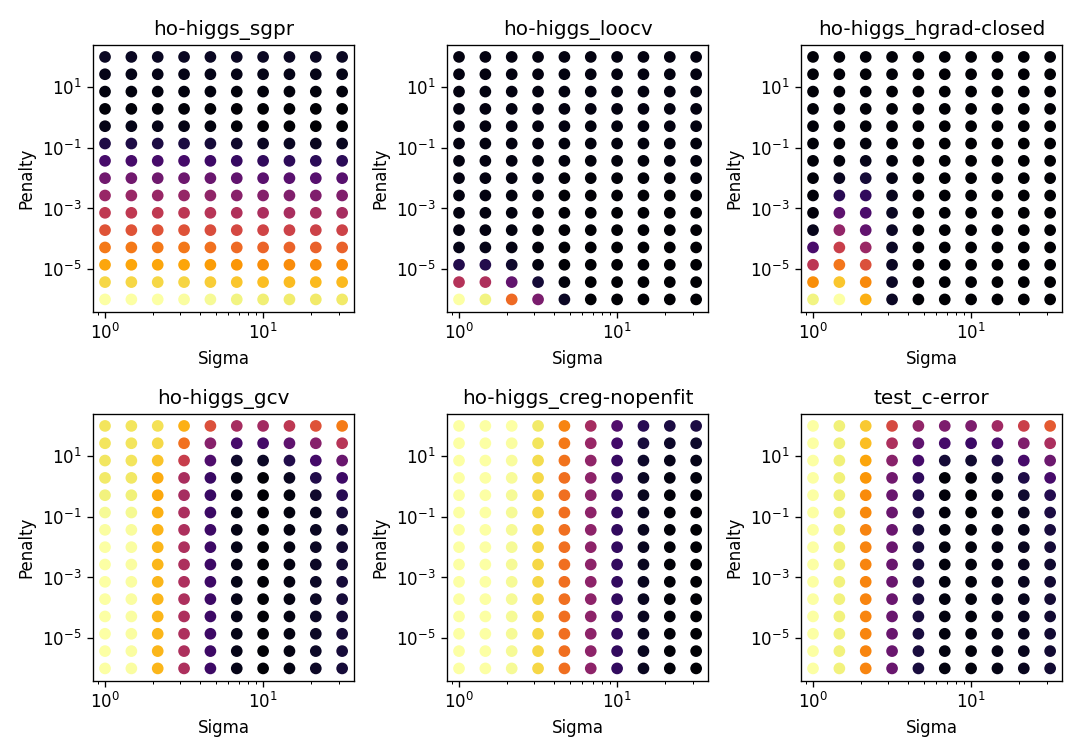

In [204]:
## test_exp_m100
plot_all_models('energy', dict_loc)
plot_all_models('boston', dict_loc)
plot_all_models('protein', dict_loc)
plot_all_models('ho-higgs', dict_loc, err_name='c-error')

<IPython.core.display.Javascript object>


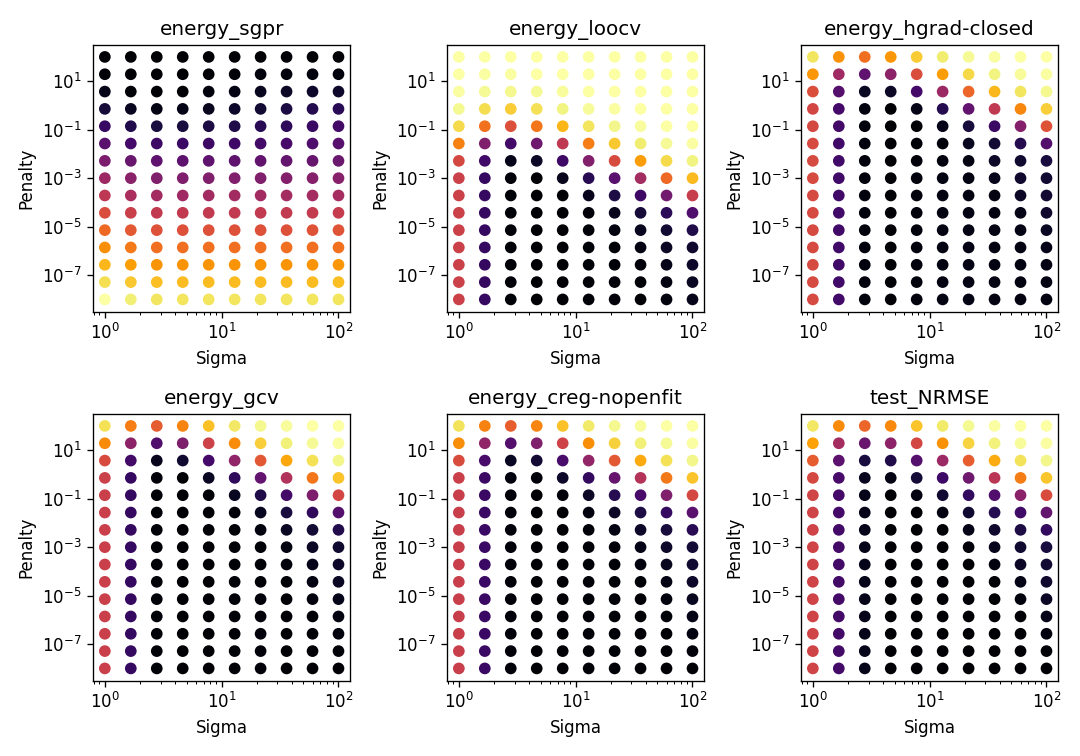

<IPython.core.display.Javascript object>


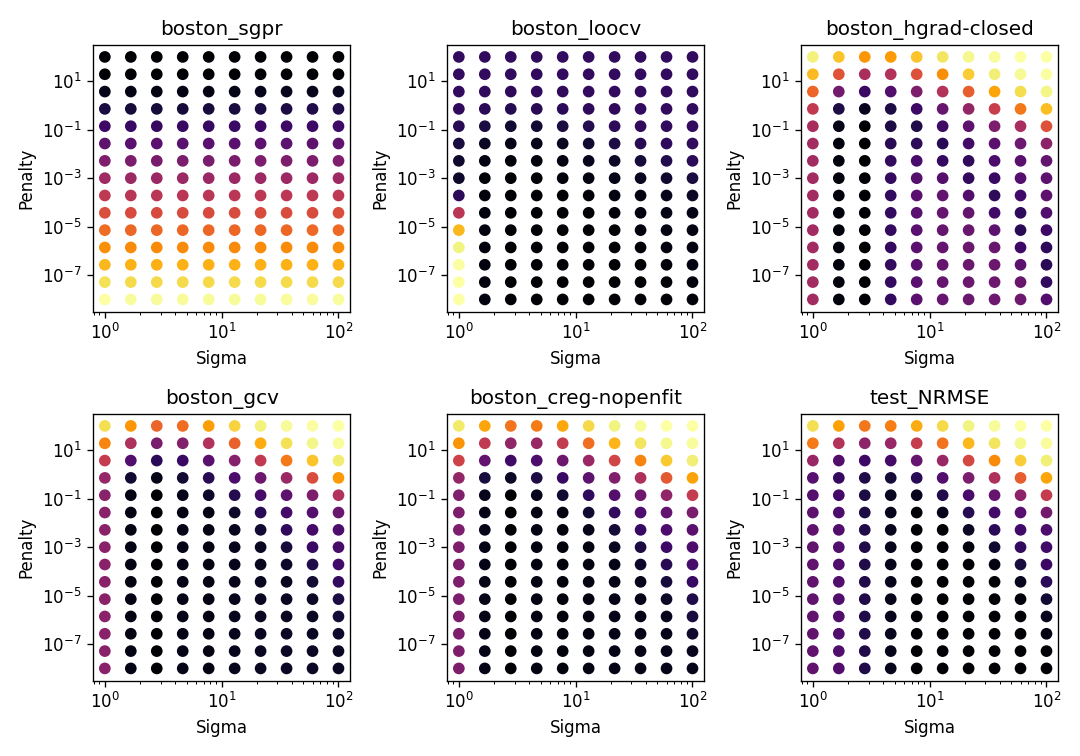

<IPython.core.display.Javascript object>


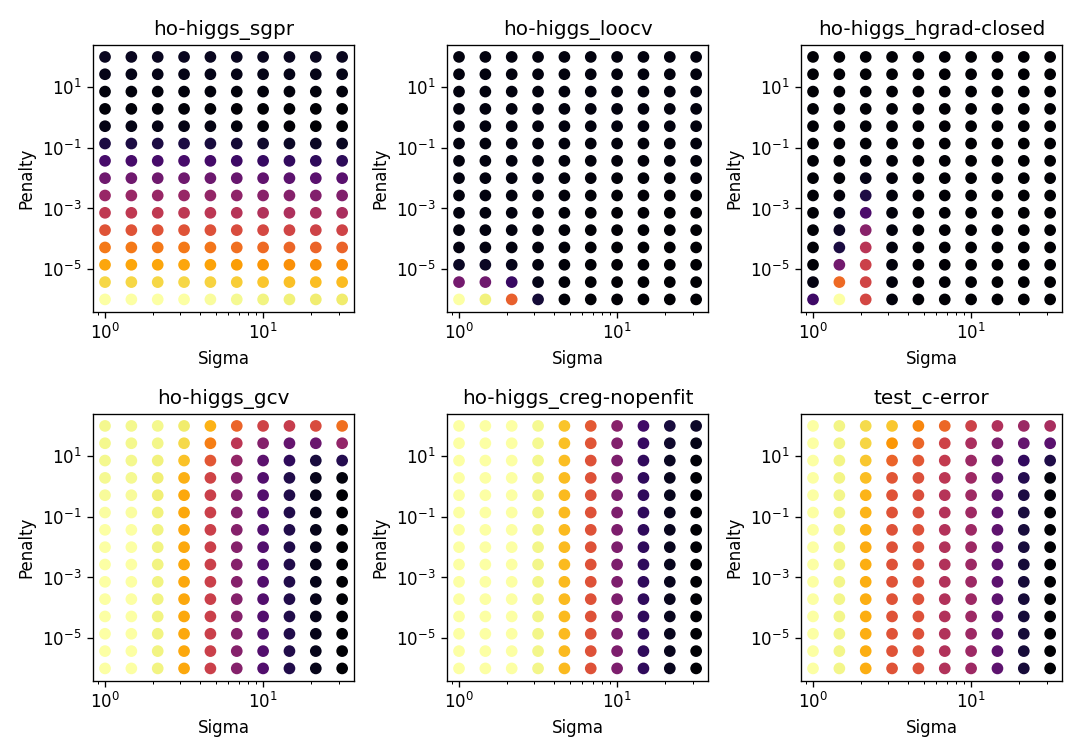

In [202]:
## test_exp_1 (m=20)
plot_all_models('energy', dict_loc)
plot_all_models('boston', dict_loc)
plot_all_models('ho-higgs', dict_loc, err_name='c-error')

## Optimization

In [285]:
def gen_data_loc_hopt(e_name, dset):
    d = {}
    for model_name in ["gcv", "loocv", "sgpr", "hgrad-closed", "hgrad-ift", "creg-penfit", "creg-nopenfit"]:
        f = f"../benchmark/logs/{dset}_hopt_{model_name}_{e_name}.pkl"
        if os.path.isfile(f):
            d[f"{dset}_{model_name}"] = f
    return d

In [305]:
data_hopt = gen_data_loc_hopt("test_hopt_m20_fast", "boston")
data_hopt.update(gen_data_loc_hopt("test_hopt_m20_slow_init0.1", "energy"))
# data_hopt.update(gen_data_loc_hopt("test_hopt_m20", "ho-higgs"))
# data_hopt.update(gen_data_loc_hopt("test_hopt_m20", "protein"))
dict_hopt = {}
for k, v in data_hopt.items():
    with open(v, 'rb') as fh:
        dict_hopt[k] = pickle.load(fh)

In [300]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import torch

def get_scalar(num):
    if isinstance(num, torch.Tensor):
        return num.item()
    return num

def opt_plot(obj_name, dict_loc, fig, ax, attr, **kwargs):
    cdict = dict_loc[obj_name]
    sigmas = [get_scalar(el['hp_sigma']) for el in cdict]
    penalties = [el['hp_penalty'] for el in cdict]
    loss = np.asarray([el[attr].item() for el in cdict[1:]])
    points = np.array([sigmas, penalties]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    norm = plt.Normalize(loss.min(), loss.max())
    lc = LineCollection(segments, norm=norm, **kwargs)
    
    lc.set_array(loss)
    lc.set_linewidth(1)
    line = ax.add_collection(lc)
    fig.colorbar(line, ax=ax)
    
    ax.set_xlim([np.min(sigmas) -0.5, np.max(sigmas) + 0.5])
    ax.set_ylim([np.min(penalties) -0.5, np.max(penalties) + 0.5])
    ax.set_xlabel('Sigma')
    ax.set_ylabel('Penalty')
    ax.set_title(obj_name)
    
def opt_plot_all_models(dset, data_dict, err_name='test_NRMSE', cbar=False):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6.3))
    ax = ax.flatten()
    for i, (obj_name, attr) in enumerate([
                                  ('%s_sgpr' % dset, err_name),
                                  ('%s_loocv' % dset, err_name),
                                  ('%s_hgrad-ift' % dset, err_name),
                                  ('%s_gcv' % dset, err_name),
                                  ('%s_creg-nopenfit' % dset, err_name),
                                  ('%s_creg-penfit' % dset, err_name)]):
        opt_plot(obj_name, data_dict, fig, ax[i], attr, cmap='inferno')

    if cbar:
        # Colorbar
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.89, 0.15, 0.05, 0.7])
        fig.colorbar(ax[-1].collections[0], cax=cbar_ax)
        fig.tight_layout(rect=(0, 0, 0.87, 1))
    else:
        fig.tight_layout()

<IPython.core.display.Javascript object>


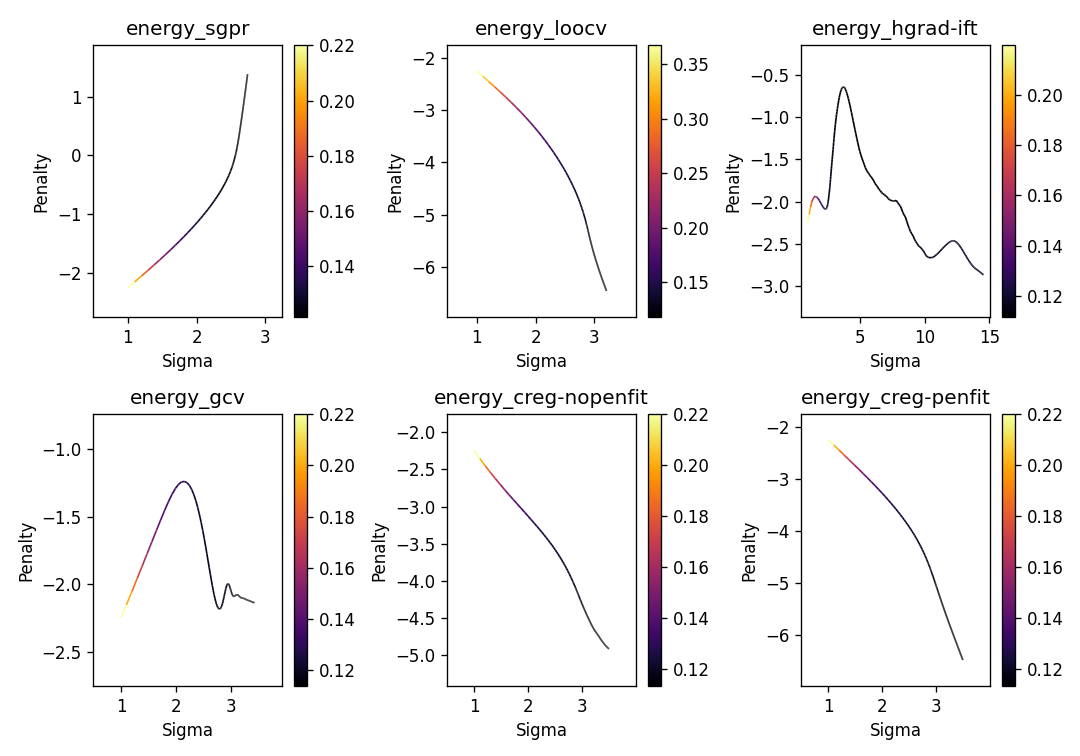

In [306]:
# slow, init 1e-1
opt_plot_all_models('energy', dict_hopt)

<IPython.core.display.Javascript object>


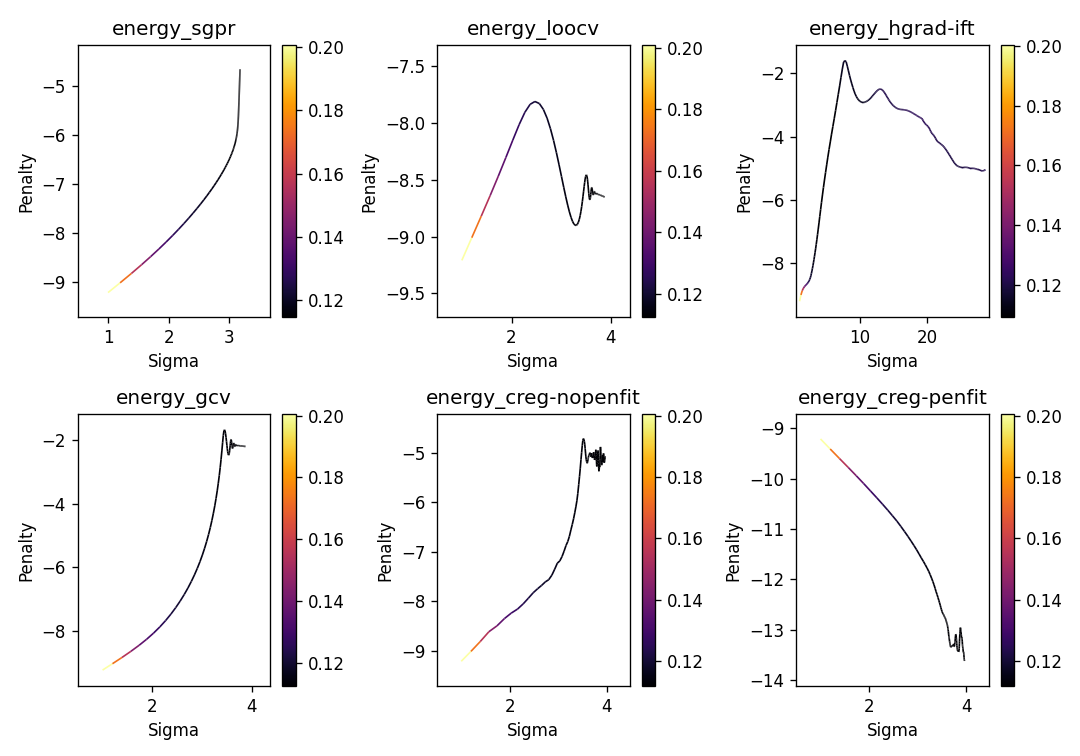

In [303]:
# fast, init 1e-4
opt_plot_all_models('energy', dict_hopt)

<IPython.core.display.Javascript object>


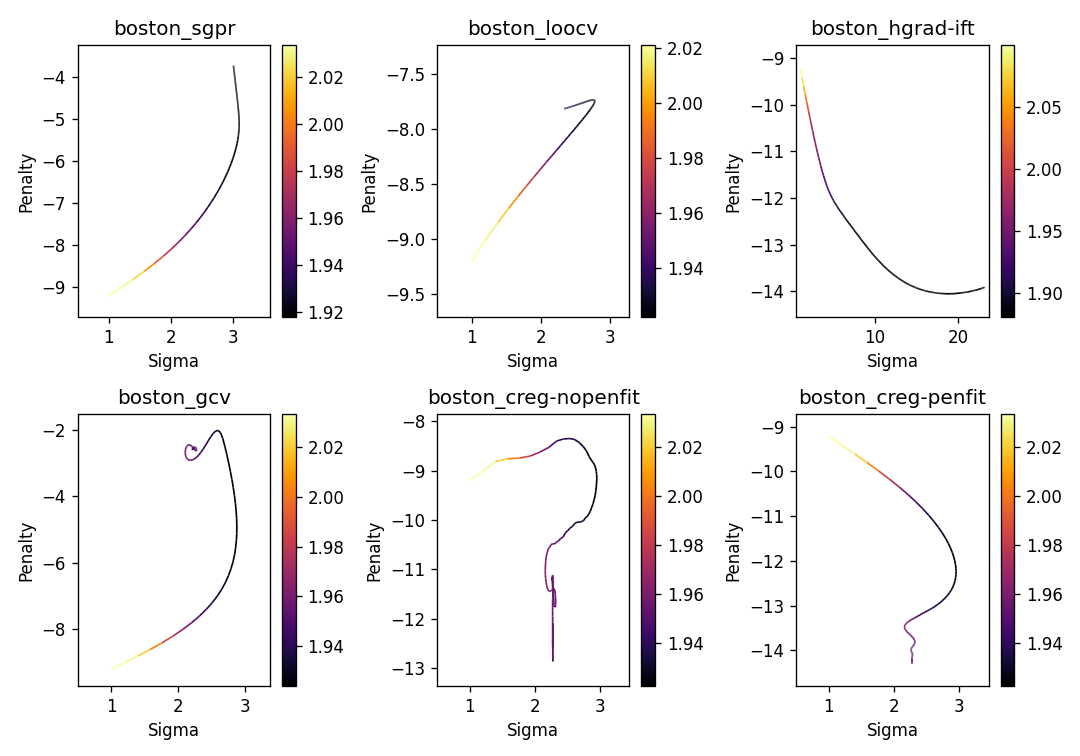

In [301]:
# opt_plot_all_models('energy', dict_hopt)
opt_plot_all_models('boston', dict_hopt)
# opt_plot_all_models('protein', dict_hopt)
# opt_plot_all_models('ho-higgs', dict_hopt, err_name='c-error')

In [262]:
dict_hopt

{'boston_gcv': [{'loss_gcv': tensor(45.8302, requires_grad=True),
   'loss': tensor(45.8302, requires_grad=True),
   'hp_sigma': tensor(2.2375, requires_grad=True),
   'hp_penalty': -9.21030044555664,
   'grad_sigma_gcv': tensor(-24.2140),
   'grad_penalty_gcv': -0.0002227930090157315},
  {'loss_gcv': tensor(43.5810, requires_grad=True),
   'loss': tensor(43.5810, requires_grad=True),
   'hp_sigma': tensor(2.2375, requires_grad=True),
   'hp_penalty': -9.110304832458496,
   'grad_sigma_gcv': tensor(-20.8040),
   'grad_penalty_gcv': -0.00022124385577626526,
   'cum_time': 0.002506256103515625,
   'train_NRMSE': 1.7926524,
   'test_NRMSE': 2.034565},
  {'loss_gcv': tensor(41.6729, requires_grad=True),
   'loss': tensor(41.6729, requires_grad=True),
   'hp_sigma': tensor(2.2375, requires_grad=True),
   'hp_penalty': -9.01032829284668,
   'grad_sigma_gcv': tensor(-17.6631),
   'grad_penalty_gcv': -0.00022131673176772892,
   'cum_time': 0.004915475845336914,
   'train_NRMSE': 1.75297,
   't